In [300]:
! sudo apt update -y && sudo apt install -qq tesseract-ocr -y 

Hit:1 http://deb.debian.org/debian bullseye InRelease
Hit:2 http://deb.debian.org/debian-security bullseye-security InRelease
Get:3 http://deb.debian.org/debian bullseye-updates InRelease [44.1 kB]
Hit:4 https://dl.yarnpkg.com/debian stable InRelease                           
Fetched 44.1 kB in 0s (150 kB/s)                
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
6 packages can be upgraded. Run 'apt list --upgradable' to see them.
tesseract-ocr is already the newest version (4.1.1-2.1).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [301]:
! pip install pytesseract sentence-transformers nltk python-levenshtein matplotlib nlpaug seaborn --quiet

In [551]:
from datasets import load_dataset
from transformers import pipeline
from matplotlib import pyplot as plt
from sentence_transformers import datasets as sent_datasets
from sklearn.preprocessing import normalize
import Levenshtein
import pytesseract
import numpy as np
import seaborn as sns
import nlpaug.augmenter.char as nac
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [303]:
ocr_kwargs: dict = dict (
  name= "OCR_Aug",
  aug_char_min= 2,
  aug_char_max= 10 ,
  aug_char_p= .3 ,
  aug_word_p= .6,
  aug_word_min= 1,
  aug_word_max= 20,
  stopwords= None,
  tokenizer= None,
  reverse_tokenizer= None,
  verbose= 0,
  stopwords_regex= None,
  min_char= 1
)

In [304]:
sample = load_dataset("lowem1/cc_news_images", split="sample")

In [305]:
row = sample[-3]

In [306]:
def process_nlp_aug(batch, col, config):
    aug = nac.OcrAug(**config)
    input_records = batch[col]
    output_records = []
    for record in input_records:
        transform = aug.augment(record)[0]
        output_records.append(transform)
    return dict(nlp_aug_text=output_records)
    
def process_ntlk_aug(batch, col):
    noise_fn = sent_datasets.DenoisingAutoEncoderDataset([]).noise_fn
    input_records = batch[col]
    output_records = []
    for record in input_records:
        transform = noise_fn(record)
        output_records.append(transform)
    return dict(tsdae_text=output_records)

def process_ocr_batch(batch, col, config="--psm 6"):
    input_records = batch[col]
    output_records = []
    for record in input_records:
        transform = pytesseract.image_to_string(image=record, config=config)
        output_records.append(transform)
    return dict(ocr_text=output_records)

def process_levenshtein_distance(batch, col1, col2, output_col=None):
    labels = batch[col1]
    output_records = []
    ocr = batch[col2]
    for s1, s2 in zip(labels, ocr):
        s1 = s1.strip("\n")
        s2 = s2.strip("\n")
        distance = Levenshtein.distance(s1, s2)
        output_records.append(distance)
    return {
        output_col: output_records
    }

def process_cardinality_distance(batch, col1, col2, output_col=None):
    labels = batch[col1]
    output_records = []
    ocr = batch[col2]
    for s1, s2 in zip(labels, ocr):
        s1_tokens = np.sort(
            np.unique(
                np.array(" ".join(s1.split("\n")).split(" "))
            )
        )
        s2_tokens = np.sort(
            np.unique(
                np.array(" ".join(s2.split("\n")).split(" "))
            )
        )
        disjoint_score = len(set(s2) - set(s1))
        output_records.append(disjoint_score)
    return {
        output_col: output_records
    }


In [310]:
sample_set = sample

In [312]:
distances_report = (
    sample_set.map(
        function=process_ocr_batch,
        fn_kwargs=dict(col="image", config="--psm 6"),
        num_proc=16,
        batched=True,
        batch_size=8
    )
    .map(
        function=process_ntlk_aug,
        fn_kwargs=dict(col="text"),
        num_proc=8,
        batched=True,
        batch_size=16,
    )
    .map(
        function=process_nlp_aug,
        fn_kwargs=dict(col="text", config=ocr_kwargs),
        num_proc=8,
        batched=True,
        batch_size=16,
    )
    .map(
        function=process_levenshtein_distance,
        fn_kwargs=dict(col1="text", col2="ocr_text", output_col="comp_distance"),
        num_proc=16,
        batched=True,
        batch_size=8,
    )
    .map(
        function=process_cardinality_distance,
        fn_kwargs=dict(col1="text", col2="ocr_text", output_col="disjoint_score"),
        num_proc=16,
        batched=True,
        batch_size=8,
    )
    .map(
        function=process_levenshtein_distance,
        fn_kwargs=dict(
            col1="text", col2="tsdae_text", output_col="tsdae_comp_distance"
        ),
        num_proc=16,
        batched=True,
        batch_size=8,
    )
    .map(
        function=process_cardinality_distance,
        fn_kwargs=dict(
            col1="text", col2="tsdae_text", output_col="tsdae_disjoint_score"
        ),
        num_proc=16,
        batched=True,
        batch_size=8,
    )
        .map(
        function=process_levenshtein_distance,
        fn_kwargs=dict(
            col1="text", col2="nlp_aug_text", output_col="nlp_aug_comp_distance"
        ),
        num_proc=16,
        batched=True,
        batch_size=8,
    )
    .map(
        function=process_cardinality_distance,
        fn_kwargs=dict(
            col1="text", col2="nlp_aug_text", output_col="nlp_aug_disjoint_score"
        ),
        num_proc=16,
        batched=True,
        batch_size=8,
    )
    .select_columns(
        [
            "text",
            "ocr_text",
            "nlp_aug_text",
            "tsdae_text",
            "comp_distance",
            "disjoint_score",
            "tsdae_comp_distance",
            "tsdae_disjoint_score",
            "nlp_aug_comp_distance",
            "nlp_aug_disjoint_score",
        ]
    )
)


Map (num_proc=16): 100%|██████████| 439/439 [00:00<00:00, 1914.71 examples/s]


<Axes: title={'center': 'Distribution of Edit Distance Per Augmentation Strategy'}, ylabel='Density'>

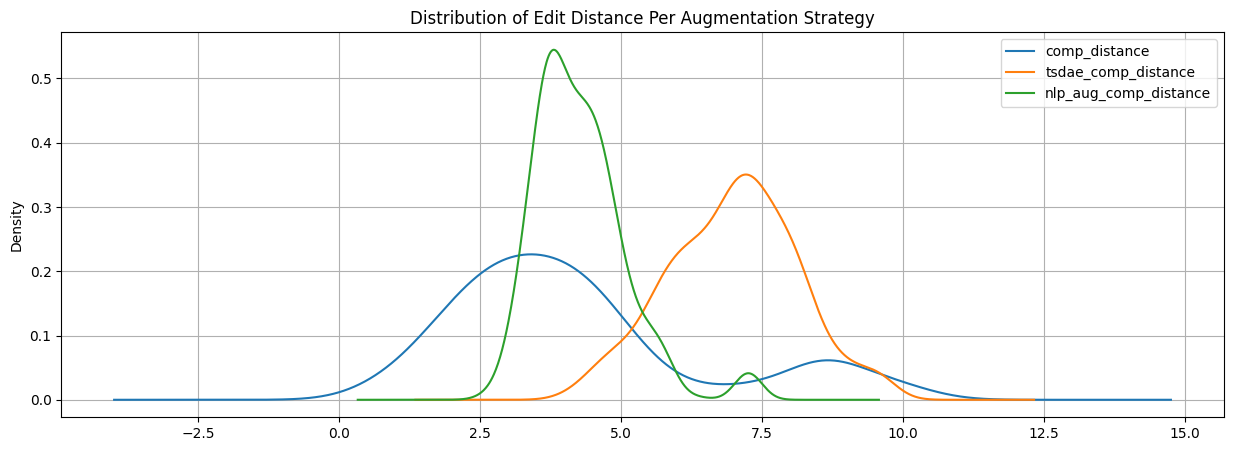

In [572]:
(
    distances_report
    .select_columns(["comp_distance", "tsdae_comp_distance", "nlp_aug_comp_distance"])
    .to_pandas()
    .apply(np.log)
    .plot
    .density(figsize=(15,5), grid=True, title="Distribution of Edit Distance Per Augmentation Strategy")
)

<Axes: title={'center': 'Edit Distance Summary Per Augmentation Strategy'}>

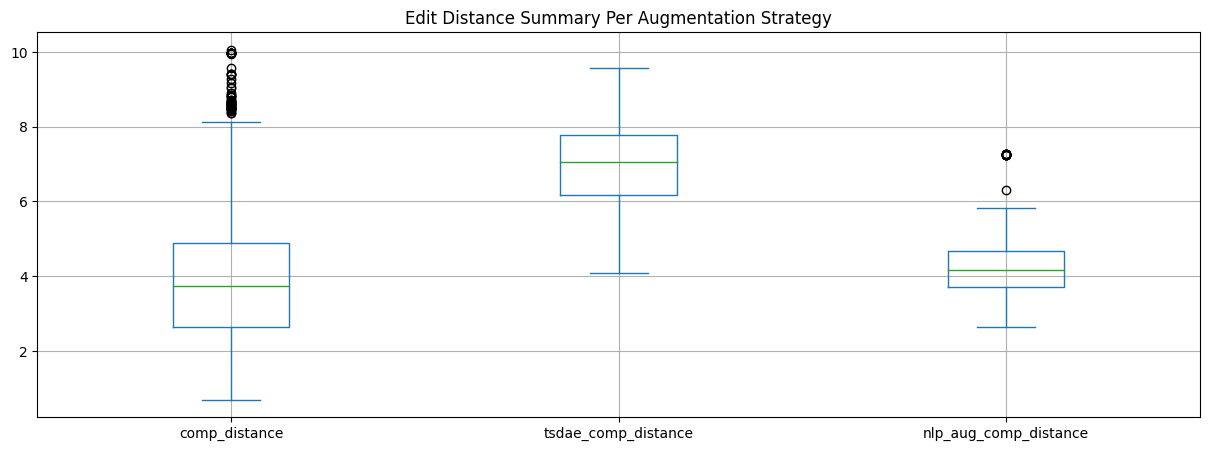

In [573]:
(
    distances_report
    .select_columns(["comp_distance", "tsdae_comp_distance", "nlp_aug_comp_distance"])
    .to_pandas()
    .apply(np.log)
    .plot
    .box(figsize=(15,5), grid=True, title="Edit Distance Summary Per Augmentation Strategy")
)

<Axes: title={'center': 'Summary of Vocabulary Disjoint Per Augmentation Strategy '}>

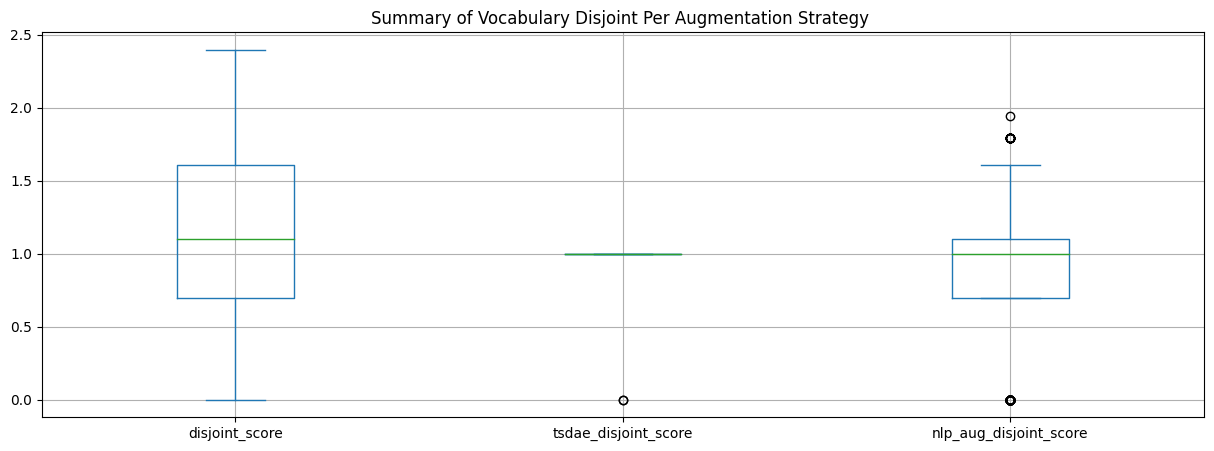

In [579]:
(
    distances_report
    .select_columns(["disjoint_score", "tsdae_disjoint_score", "nlp_aug_disjoint_score"])
    .to_pandas()
    .apply(np.log)
    .replace([np.inf, -np.inf], 1)
    .plot
    .box(figsize=(15,5), grid=True, title="Summary of Vocabulary Disjoint Per Augmentation Strategy ")
)

In [580]:
(
    distances_report.select_columns([
        "comp_distance",
        "tsdae_comp_distance",
        "nlp_aug_comp_distance"
    ])
    .to_pandas()
    .apply(np.log)
    .replace([np.inf, -np.inf], 1)
    .describe()
)

,comp_distance,tsdae_comp_distance,nlp_aug_comp_distance
count,439.000000,439.000000,439.000000
mean,4.209219,6.984248,4.274464
std,2.263670,1.137885,0.816949
min,0.693147,4.094345,2.639057
25%,2.639057,6.170656,3.713572
50%,3.737670,7.060476,4.158883
75%,4.879000,7.783016,4.672829
max,10.065861,9.581076,7.261225


In [322]:
distances_report.select_columns(["disjoint_score", "tsdae_disjoint_score", "nlp_aug_disjoint_score"], ).to_pandas().describe()

,disjoint_score,tsdae_disjoint_score,nlp_aug_disjoint_score
count,439.000000,439.000000,439.000000
mean,3.612756,0.004556,2.084282
std,2.211514,0.067420,1.739864
min,1.000000,0.000000,0.000000
25%,2.000000,0.000000,1.000000
50%,3.000000,0.000000,2.000000
75%,5.000000,0.000000,3.000000
max,11.000000,1.000000,7.000000


In [466]:
summarization_pipeline = pipeline("summarization", model="google/byt5-small")
summarization_pipeline2 = pipeline("summarization", model="t5-small")

In [467]:
some_text = distances_report.select_columns(["text"])[0]["text"]
len(some_text)
some_text

"Emmanuel Macron, head of the political movement En Marche !, or Onwards !, and candidate for the 2017 presidential election, poses before taking part in the show ''Elysee 2017'' on French television channel TF1 in Paris, France, April 27, 2017. REUTERS/Eric Feferberg/Pool\nPARIS A new Odoxa survey of voter intentions said centrist Emmanuel Macron would win the French presidency in a May 7 vote, but that his share of the vote would be 59 percent, down four percentage points from its previous survey.\nThe survey, carried out over April 26-27 and published on Friday, saw his far right rival Marine Le Pen on 41 percent, up four points compared with the previous survey on April 24-25.\nThe poll showed that 40 percent of supporters of the defeated first-round French presidential candidate Jean-Luc Melenchon would vote Emmanuel Macron, while half of Francois Fillon voters would do the same.\nMore than 40 percent of Melenchon voters plan to abstain, the poll also showed.\n(Reporting by Maya N

In [468]:
some_text2 = summarization_pipeline(some_text, max_new_tokens=500)[0]["summary_text"]
some_text2

Both `max_new_tokens` (=500) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


' Macron would win the French presidential election in a May 7 vote.\n(Reporting by Maya Nikolaeva; Editing by Maya Nikolaeva; Editing by Maya Nikolaeva; Editing by Maya Nikolaeva; Editi'

In [469]:
some_text3 = summarization_pipeline2(some_text, max_new_tokens=3, min_length=1)[0]["summary_text"]
some_text3


Both `max_new_tokens` (=3) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


'Emmanuel Macron'

In [512]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: b950063b-31eb-4ff9-bea5-2fc862ea047a)')' thrown while requesting HEAD https://huggingface.co/facebook/bart-large-cnn/resolve/main/config.json


In [517]:
def process_summarization_labels(text, i = 2, upper_limit=64):
    max_tokens = 2**i
    if max_tokens != upper_limit:
        i += 1
        process_summarization_labels(text, i=i)
    text = summarizer(text, max_new_tokens=max_tokens, max_length=max_tokens, min_length=1)[0]["summary_text"]
    # print(text)
    return text


In [520]:
cats = []
for  record in distances_report.select_columns(["text"]).select(range(50)):
    text = record["text"]
    label = process_summarization_labels(text)
    cats.append(dict(text=text, label=label))

Both `max_new_tokens` (=64) and `max_length`(=64) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=32) and `max_length`(=32) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=16) and `max_length`(=16) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=8) and `max_length`(=8) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_

IndexError: index out of range in self

In [523]:
import pandas as pd
pd.DataFrame(cats)


,text,label
0,"Emmanuel Macron, head of the political movemen...",Emmanuel
1,"Charles Robert Pinkerton, 37, of Morgantown, d...",Charles Robert
2,": Shares in Facebook, the world's largest soci...",Facebook shares
3,Ashley Benson made sure to turn heads as she s...,The Pretty
4,"WHITE BEAR LAKE, Minn. (AP)  Prosecutors say ...",Robert James
5,NEW YORK CITY — The Weinstein Co. filed for ba...,The Weinstein
6,Apple targets supply chain efficiency through ...,Apple launches
7,"A well-guarded par-4, the fourth hole is a tou...",The 475
8,"SAN FRANCISCO (KRON) — When it rains, there is...",KRON
9,"IBM\nIt's smaller than a grain of salt, but it...",IBM
